# Notebook demonstrating the use of Timeseriesai for generating predictions
https://github.com/timeseriesAI/timeseriesAI

## The below is done using the tutorial data set (one state, one season) and is a very small dataset so the results are only intended for use on how to use this, not necessarily what the ML capability is

### uses env timeseriesai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from tsai.all import *
from joblib import Parallel, delayed
from openavalancheproject.tsai_utilities import *


In [3]:
import mlflow
from azureml.core import Workspace

In [4]:
ws = Workspace.from_config()
mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

In [19]:
data_root = '/media/scottcha/Data2/OAPMLData/'

ml_path = data_root + '/5.MLData/'
num_features = 771
interpolation = 1
label = 'Day1DangerAboveTreeline'
file_label = 'co_day1above_nooversample_small'
#file_label = 'day1above'
#label = 'Day1DangerAboveTreeline'

In [8]:
mlflow.set_experiment(file_label)

In [9]:
mlflow.log_param('TrainSamples', 5000)

In [20]:
#load the full X datafile which has both Train and Test concated
X = np.load(ml_path + '/X_all_' + file_label + '.npy', mmap_mode='r')

In [21]:
utils = TSAIUtilities(X, label)

In [22]:
means_fn = ml_path + '/feature_means_interpolation' + str(interpolation) + '_' + file_label + 'x.npy'
std_fn = ml_path + '/feature_std_interpolation' + str(interpolation)  + '_' + file_label +   'x.npy'

In [23]:
means_fn

'/media/scottcha/Data2/OAPMLData//5.MLData//feature_means_interpolation1_co_day1above_nooversample_smallx.npy'

In [24]:
feature_means = utils.get_feature_means(means_fn)

In [25]:
feature_std = utils.get_feature_std(std_fn)

In [26]:
feature_means[:10]

[8.472752e-05,
 0.00012723751,
 4.2632142e-05,
 9.90879e-05,
 0.00011797031,
 8.086408e-05,
 9.836408e-05,
 0.00010803463,
 8.920958e-05,
 0.00010609991]

In [27]:
feature_std[:10]

[4.5926772e-05,
 5.907273e-05,
 5.868515e-05,
 1.9561787e-05,
 3.2205167e-05,
 3.0123063e-05,
 1.9563266e-05,
 2.1312619e-05,
 2.0690946e-05,
 2.8365175e-05]

In [28]:
X = X[:,:,:]

In [17]:
mlflow.log_param('Lookback', 30)

In [34]:
#read in the corresponding label files and concat them
#can get the right values here based on the contents of hte ml_path directory


y_train_df = pd.read_parquet(ml_path + '/y_train_batch_' + str(0) + '_' + file_label + '.parquet')  
y_train_df_1 = pd.read_parquet(ml_path + '/y_train_batch_' + str(1) + '_' + file_label + '.parquet')  

y_test_df = pd.read_parquet(ml_path + '/y_test_batch_' + str(i) + '_' + file_label + '.parquet')  
y_df = pd.concat([y_train_df,y_train_df_1, y_test_df]).reset_index(drop=True)

In [35]:
y_df.shape

(12000, 302)

In [36]:
no_dupes = y_df.drop_duplicates()

In [37]:
no_dupes.shape

(12000, 302)

In [38]:
y_df['season'].value_counts()

18-19    2758
17-18    2166
20-21    2000
15-16    1797
16-17    1693
19-20    1586
Name: season, dtype: int64

In [39]:
y_df['parsed_date'].value_counts()

2017-01-10    111
2019-03-07    110
2019-03-13    103
2020-12-29     96
2019-03-09     96
             ... 
2016-02-18      1
2015-11-19      1
2015-12-04      1
2017-02-18      1
2017-02-03      1
Name: parsed_date, Length: 933, dtype: int64

In [40]:
y_df[label].value_counts()

Low             3017
Considerable    3017
Moderate        3016
High            2950
Name: Day1DangerAboveTreeline, dtype: int64

In [41]:
y, cat_dict = utils.get_y_as_cat(y_df)
cat_dict

{0: 'Low', 1: 'Moderate', 2: 'Considerable', 3: 'High'}

In [42]:
y.shape

(12000,)

In [43]:
#index file which indicates which rows in X are train or test
#be carful these don't overlap
train_test_split = 10000
num_y = 2000
#can use a smaller train subset to make development faster
splits_2 = (L([i for i in range(0,train_test_split)]).shuffle(), L([i for i in range(train_test_split,train_test_split+num_y)]).shuffle())

In [44]:
splits_2

((#10000) [8568,3354,7649,9913,2793,6648,179,1768,937,4117...],
 (#2000) [11587,11488,11182,11224,11248,10270,11333,10259,11925,10628...])

In [45]:
#load and check the means and std deviations
feature_means = (np.nan_to_num(feature_means))

In [46]:
np.isnan(feature_means).any()

False

In [47]:
feature_std = (np.nan_to_num(feature_std, nan=1.0))

In [48]:
np.isnan(feature_std).any()

False

In [49]:
X.shape

(12000, 771, 180)

In [50]:
#create the dataset
tfms = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits_2, inplace=True)

In [51]:
X[0]

memmap([[          nan,           nan,           nan, ..., 1.0085715e-04,
         1.0842857e-04, 1.0028571e-04],
        [          nan,           nan,           nan, ..., 1.8800001e-04,
         1.4900000e-04, 1.6200000e-04],
        [          nan,           nan,           nan, ..., 5.0999999e-05,
         5.9999998e-05, 6.6000001e-05],
        ...,
        [          nan,           nan,           nan, ..., 6.5714288e+00,
         4.5714288e+00, 1.8571428e+00],
        [          nan,           nan,           nan, ..., 7.0000000e+00,
         5.0000000e+00, 2.0000000e+00],
        [          nan,           nan,           nan, ..., 5.0000000e+00,
         3.0000000e+00, 1.0000000e+00]], dtype=float32)

<AxesSubplot:title={'center':'2'}>

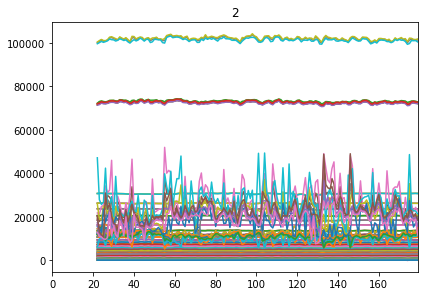

In [64]:
#check on set
show_at(dsets.train, 0)

In [65]:
class TSStandardizeNanMeanReplaceNan(Transform):
    #method to standardize each batch while also replacing any nans with the mean value before standarization
    "Standardize/destd batch of `NumpyTensor` or `TSTensor`"
    parameters, order = L('mean', 'std'), 99
    def __init__(self, mean=None, feature_means=None, std=None, feature_std=None, by_sample=False, by_var=False, verbose=False):
        self.mean = tensor(mean) if mean is not None else None
        self.std = tensor(std) if std is not None else None
        self.feature_means = feature_means
        self.feature_std = feature_std
        self.by_sample, self.by_var = by_sample, by_var
        if by_sample and by_var: self.axes = (2)
        elif by_sample: self.axes = (1, 2)
        elif by_var: self.axes = (0, 2)
        else: self.axes = ()
        self.verbose = verbose

    @classmethod
    def from_stats(cls, mean, std): return cls(mean, std)

    def setups(self, dl: DataLoader):
        if self.mean is None or self.std is None:
            pv(f'{self.__class__.__name__} setup mean={self.mean}, std={self.std}, by_sample={self.by_sample}, by_var={self.by_var}', self.verbose)
            x, *_ = dl.one_batch()
            x = torch.where(torch.isnan(x), torch.zeros_like(x), x)
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            pv(f'mean: {self.mean}  std: {self.std}\n', self.verbose)

    def encodes(self, x:(NumpyTensor, TSTensor)):
        fill_values = torch.zeros_like(x)
        std_values = torch.zeros_like(x)       
        for i in range(0,x.shape[1]):
            fill_values[:,i,:] = torch.full_like(x[:,i,:], self.feature_means[i])
            std_values[:,i,:] = torch.full_like(x[:,i,:], self.feature_std[i])
        
        x = torch.where(torch.isnan(x), fill_values, x)
        
        if self.by_sample:        
            self.mean, self.std = x.mean(self.axes, keepdim=self.axes!=()), x.std(self.axes, keepdim=self.axes!=()) + 1e-7
            
        t = (x - fill_values) / std_values
        del fill_values, std_values
        return torch.where(torch.isnan(t), torch.zeros_like(t), t)

In [55]:
??TSStandardize

In [67]:
#create the dataloader
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64], batch_tfms=[TSStandardizeNanMeanReplaceNan(feature_means=feature_means, feature_std=feature_std)], num_workers=0)

In [61]:
#check both the train and test sets to ensure that there aren't full rows with all nulls

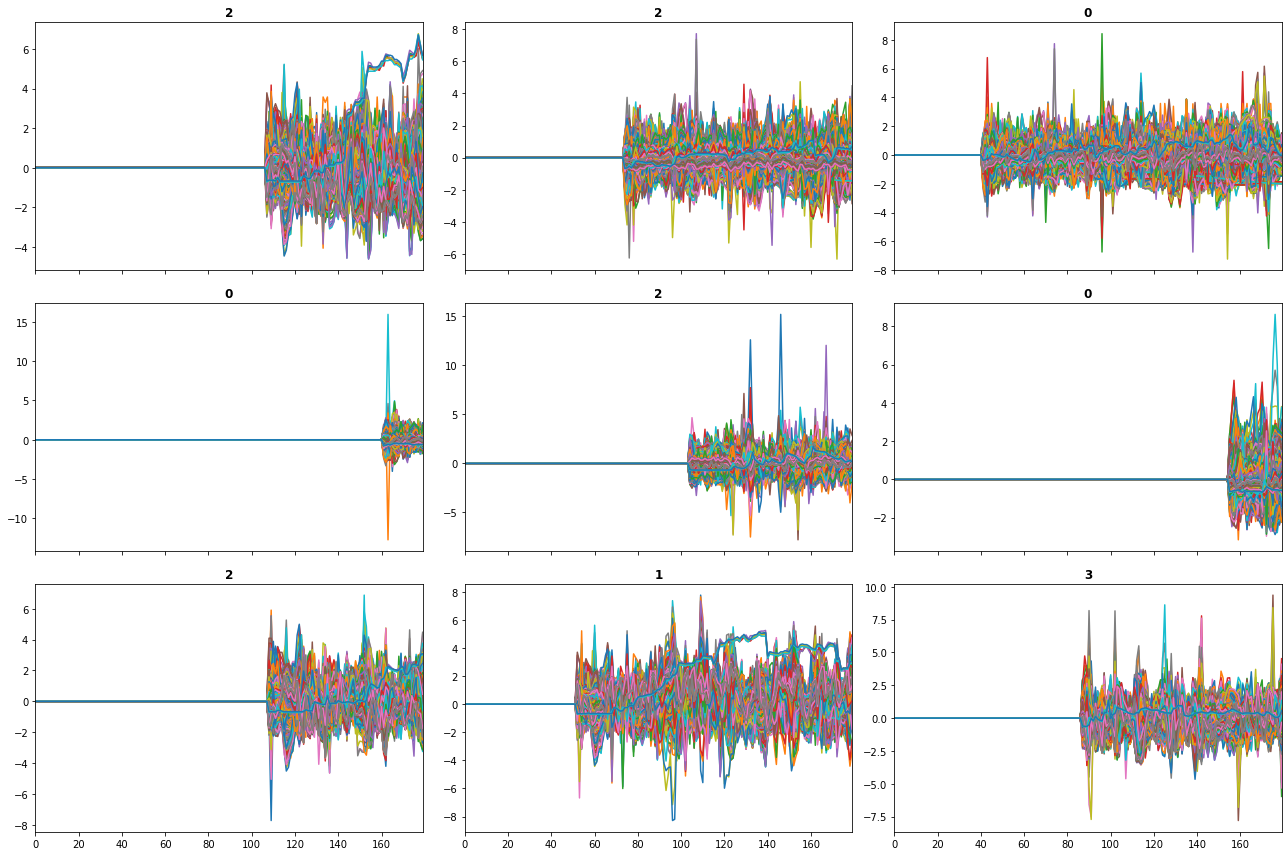

In [68]:
dls.show_batch()

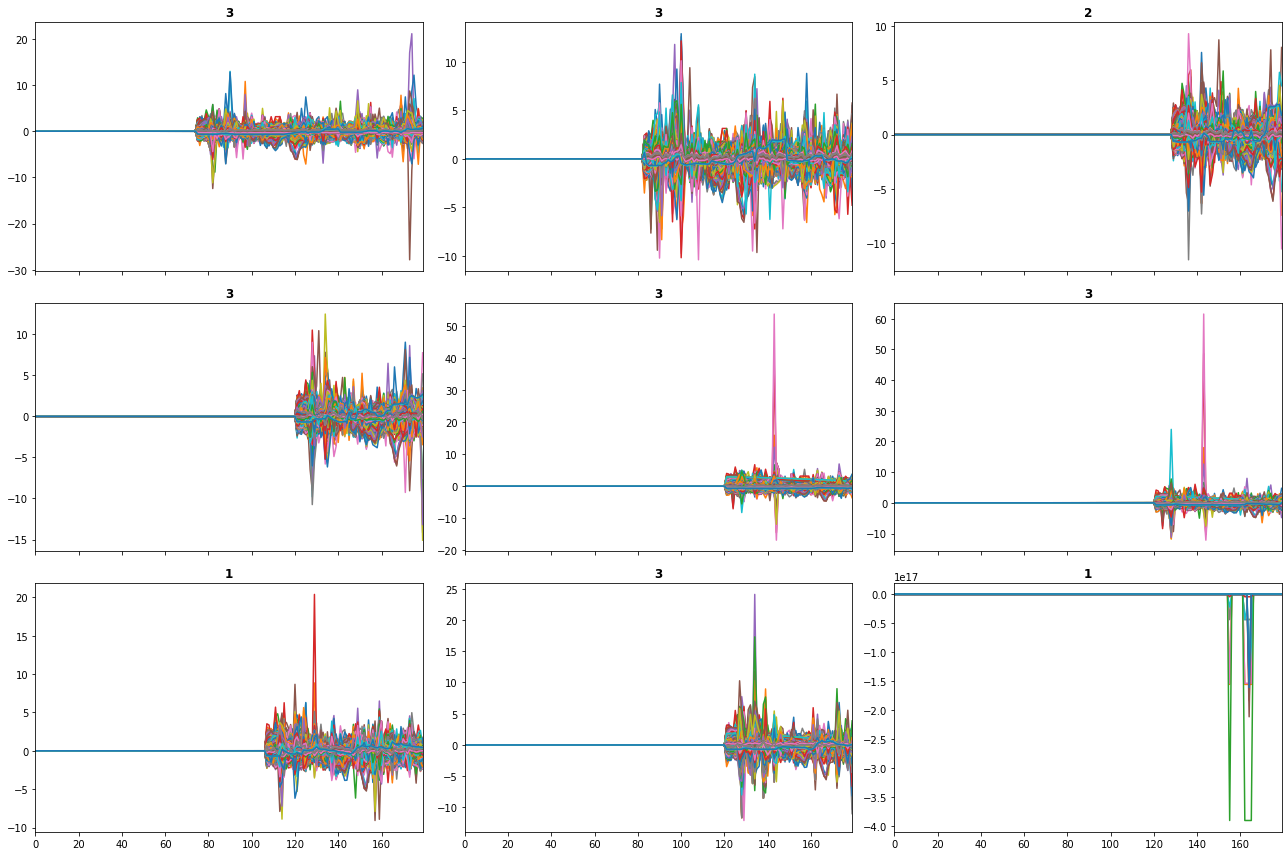

In [69]:
dls.valid.show_batch()

In [70]:
dls.c

4

In [71]:
dls.vars

771

# Lets try and train a model, in the tutorial case we are using an extremely small dataset so no conclusions should be drawn from these results they are for illustrative purposes only

In [78]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)

In [72]:
model = LSTM(dls.vars, 
                    dls.c,
                    hidden_size=200, 
                    n_layers=5, 
                    rnn_dropout=.8,
                    bidirectional=False,
                    fc_dropout=.8)
learn = Learner(dls, model, metrics=accuracy)

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.0014454397605732083)

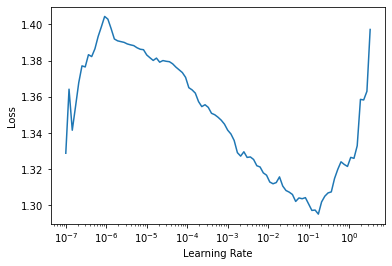

In [79]:
learn.lr_find()

In [45]:
mlflow.log_param('lr', 1e-2)

In [80]:
#without oversampling
learn.fit_one_cycle(7, lr_max=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.883516,nan,0.310000,00:19
1,0.691353,nan,0.412000,00:19
2,0.607769,nan,0.410000,00:19
3,0.488945,nan,0.477500,00:19
4,0.390598,nan,0.457500,00:19
5,0.304832,nan,0.445000,00:19
6,0.242318,nan,0.456500,00:19


In [47]:
mlflow.log_param('Model', str(type(model)))

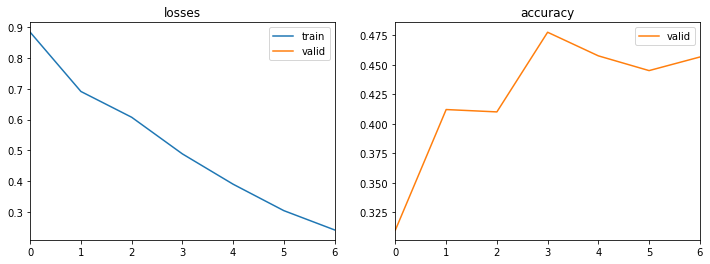

In [81]:
learn.recorder.plot_metrics()

### Results


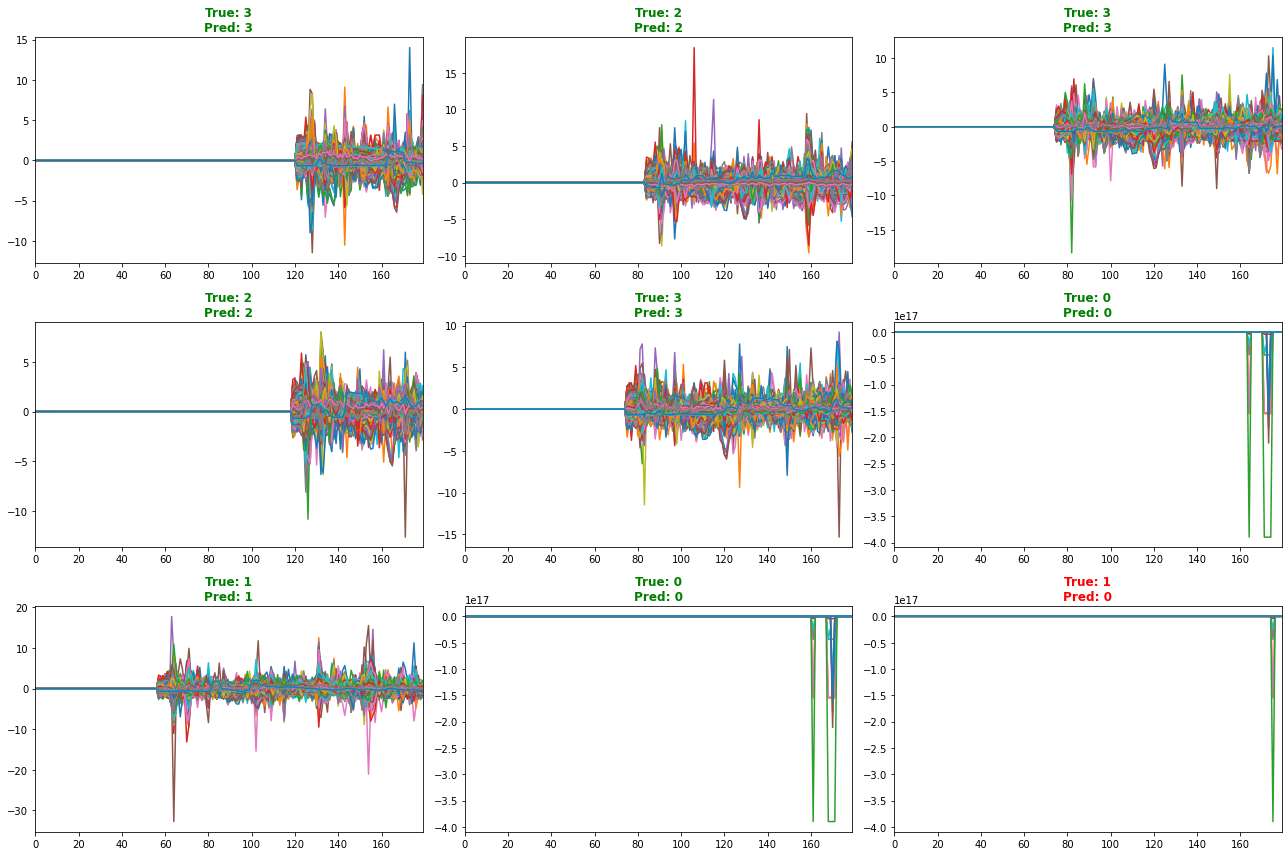

In [76]:
learn.show_results()

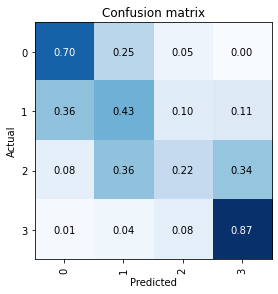

In [77]:
#d,t = flatten_check(interp.decoded, interp.targs)
#print(str(skm.accuracy_score(t, d)))
interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

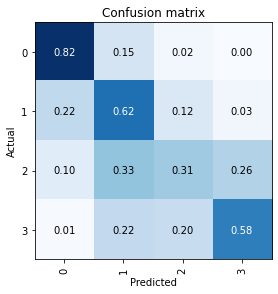

In [90]:
#100 features
interp = ClassificationInterpretation.from_learner(learn)
conf_matrix = interp.plot_confusion_matrix(normalize=True)

In [173]:
mlflow.log_param('Model', str(type(m)))
mlflow.log_param('Num Hidden ', h)
mlflow.log_param('Num Layers ', l)
mlflow.log_param('RNN Dropout ',d)
mlflow.log_param('FC Dropout ', f)
mlflow.log_param('Bidirectional ',b)

In [174]:
cm = interp.confusion_matrix()
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
for r in range(len(cm)):
    for c in range(len(cm[r])):
        mlflow.log_metric('Actual ' + str(r) + ' Predicted ' + str(c), cm[r,c])

d,t = flatten_check(interp.decoded, interp.targs)
mlflow.log_metric('Test Accuracy', skm.accuracy_score(t, d))

In [175]:
mlflow.end_run()

In [37]:
from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

In [91]:
net = learn.model.cpu()

In [92]:
b = dls.one_batch()

In [93]:
test_input_tensor = b[0].type(torch.FloatTensor)

In [94]:
test_labels = b[1].cpu().data.numpy()

In [95]:
out_probs = net(test_input_tensor).detach().cpu().numpy()
out_classes = np.argmax(out_probs, axis=1)
train_accuracy = sum(out_classes == test_labels) / len(test_labels)
print("Accuracy:", train_accuracy )

Accuracy: 0.625


In [43]:
mlflow.log_metric('Train Accuracy', train_accuracy)

NameError: name 'mlflow' is not defined

In [96]:
ig = IntegratedGradients(net)

In [97]:
#test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

In [36]:
feature_names = pd.read_csv(ml_path + '/FeatureLabels_' + file_label + '.csv')
feature_names = feature_names['0'].sort_values().values

In [37]:
feature_names = feature_names[feature_filter]

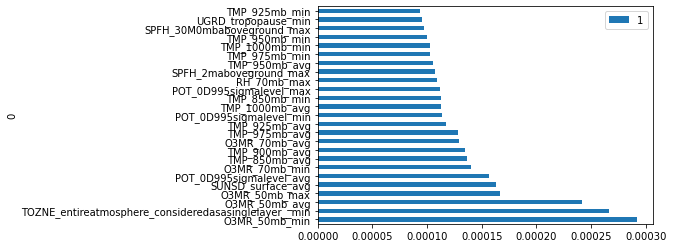

In [101]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    pd.DataFrame(zip(feature_names, np.mean(importances, axis=(0,2)))).sort_values(1, ascending=False)[:25].plot.barh(x=0, y=1)

visualize_importances(feature_names, attr)

In [50]:
top_features =  pd.DataFrame(zip(feature_names, np.mean(attr, axis=(0,2))), columns=['Feature', 'Importance']).sort_values('Importance', ascending=False)

In [51]:
top_features.to_csv('../Scratch/Notebooks/' + '/FeatureImportances.csv')

In [29]:
top_features = pd.read_csv('../Scratch/Notebooks/' + '/FeatureImportances.csv')

In [85]:
orig_X = X

In [86]:
orig_feature_means = feature_means

In [87]:
orig_feature_std = feature_std

In [134]:
mlflow.end_run()

In [88]:
feature_filter = top_features[:100].index

In [89]:
X = orig_X[:, feature_filter, :]
feature_means = orig_feature_means[feature_filter]
feature_std = orig_feature_std[feature_filter]

In [35]:
fill_values = torch.zeros_like(TSTensor(X))
for i in range(0,X.shape[1]):
    fill_values[:,i,:] = torch.full_like(TSTensor(X[:,i,:]), feature_means[i])
        
X_noNan = torch.where(torch.isnan(TSTensor(X)), fill_values, TSTensor(X))

In [40]:
X_noNan[:,:,-30:].shape

torch.Size([6000, 100, 30])